<a href="https://colab.research.google.com/github/ravisiv/APIClassification/blob/main/APIClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Classification Of APIs using API Summaries

#### Ravi Sivaraman

In [34]:
import pandas as pd
import yaml
import io



In [35]:
base_path = "/content/drive/MyDrive/APIs/"
api_df = pd.read_csv("/content/drive/MyDrive/APIs/apis.csv")

In [36]:
## TODO: rewrite it as get_n_tags()

def get_three_tags(tagslist):
    index = 0
    threetags = []
    for tag in range(0,3):
        try:
            item  = tagslist[tag]
            threetags.append(item)
        except IndexError:
            threetags.append('')
    return threetags



### Parse all APIs

In [37]:
import re
apis = []
for index, row in api_df.iterrows():
    try:
        with open(base_path+row['API'], 'r') as stream:
            data_loaded = yaml.safe_load(stream)
            data_items =  list(data_loaded.keys())
            api_type = data_items[0]
            try:
                for key, val in data_loaded.items():
                    if key == "paths":
                        if api_type == "swagger":
                            for key2, val2 in val.items():
                                basePath = data_loaded["basePath"]
                                host = data_loaded["host"]
                                api_name = key2
                                api_http_type = list(val2.keys())[0]
                                api_summary = val2[api_http_type]['summary']
                                api_tags = val2[api_http_type]['tags']
                                api_row = [api_type,host,basePath,api_name,api_http_type,api_summary] + get_three_tags(api_tags)
                                api_summary_2 = ""
                                if api_summary:
                                    api_summary_2 = re.sub('\W+',' ', api_summary.lower() ) 
                                    if api_tags and type(api_tags) is list:
                                        api_summary_2 += " " + " ".join(api_tags)
                                        api_summary_2 =  api_summary_2.lower()

                                apis.append(api_row + ["".join(api_summary_2)] )
                        if api_type == "openapi":
                            api_name = list(val.keys())[0]
                            api_http_type = list(val[api_name].keys())[0]
                            api_summary = val[api_name][api_http_type]['summary']
                            api_tags = val[api_name][api_http_type]['tags']
                            api_row = [api_type,host,basePath,api_name,api_http_type,api_summary] + get_three_tags(api_tags)
                            api_summary_2 = ""
                            if api_summary:
                                api_summary_2 = re.sub('\W+',' ', api_summary.lower() ) 
                                if api_tags and type(api_tags) is list:
                                    api_summary_2 += " " + " ".join(api_tags)
                                    api_summary_2 = api_summary_2.lower()
                            apis.append(api_row + ["".join(api_summary_2)] )


            except Exception as e:
                continue
    except:
        continue
apis_df = pd.DataFrame.from_records(apis, columns=['api_type','host','basePath','api_name','api_http_type','api_summary','tag1', 'tag2', 'tag3', "api_summary_2"])


#Reference: https://towardsdatascience.com/how-to-cluster-similar-sentences-using-tf-idf-and-graph-partitioning-in-python-5fb70627a4e0


In [59]:
def cosine_similarity(text1, text2):
    
    X_list = word_tokenize(text1) 
    Y_list = word_tokenize(text2)

    # sw contains the list of stopwords
    sw = stopwords.words('english') 
    l1 =[];l2 =[]

    # remove stop words from the string
    X_set = {w for w in X_list if not w in sw} 
    Y_set = {w for w in Y_list if not w in sw}

    # form a set containing keywords of both strings 
    rvector = X_set.union(Y_set) 
    for w in rvector:
        if w in X_set: l1.append(1) # create a vector
        else: l1.append(0)
        if w in Y_set: l2.append(1)
        else: l2.append(0)
    c = 0

    # cosine formula 
    for i in range(len(rvector)):
        c+= l1[i]*l2[i]
    cosine = c / float((sum(l1)*sum(l2))**0.5)
    return cosine



In [60]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

stemmer = StemmerFactory().create_stemmer()
stopwords = StopWordRemoverFactory().get_stop_words()

def text_preprocess(series, stemmer, stopwords):
    df = series.str.replace("\n\t",  " ")
    df = df.str.replace(r"[^a-zA-Z ]+", "")
    df = df.str.lower()
    df = df.apply(lambda x: ' '.join([stemmer.stem(item) for item in x.split() if item not in stopwords]))
    return df

apis_df['processed_text'] = text_preprocess(apis_df['api_summary_2'], stemmer, stopwords)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':


In [61]:
apis_df.to_csv("apis_data.csv")

In [42]:
import fasttext

In [64]:
import fasttext

#model = fasttext.train_unsupervised('/Users/ravis/Downloads/wiki-news-300d-1M.vec')
apis_df['vec'] = apis_df['processed_text'].apply(lambda x: model.get_sentence_vector(x))

In [44]:
apis_df['vec'] = apis_df['processed_text'].apply(lambda x: model.get_sentence_vector(x))

In [65]:
apis_df['vec']

0       [0.03719435, -0.015253557, -0.04589598, -0.021...
1       [-0.008268558, 0.0031177406, -0.022891957, -0....
2       [0.04091386, -0.046491396, 0.0038976828, -0.00...
3       [0.025302937, 0.015915517, -0.016523104, 0.008...
4       [-0.003093318, 0.0022154166, -0.012527056, 0.0...
                              ...                        
3673    [0.11873129, -0.07086635, -0.02338354, 0.06951...
3674    [0.08758139, -0.109601915, 0.092438266, 0.0939...
3675    [0.10316494, -0.010101309, 0.04449649, 0.09270...
3676    [0.05305753, -0.04358753, 0.06328352, 0.038250...
3677    [-0.04946267, 0.014706102, 0.014475949, 0.0375...
Name: vec, Length: 3678, dtype: object

In [63]:
#model.save_model("apimodel.bin")

model = fasttext.load_model("apimodel.bin")

In [66]:

X =apis_df['vec']

In [67]:
df_x = pd.DataFrame.from_records(apis_df['vec'])

In [68]:
X = df_x.values

k 2
k 3
k 4
k 5
k 6
k 7
k 8
k 9
k 10
k 11
k 12
k 13
k 14
k 15
k 16
k 17
k 18
k 19


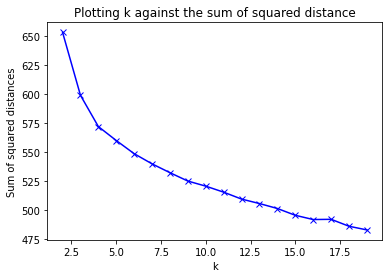

In [69]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
sum_of_squared_distances = []
K = range(2,20)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X)
    sum_of_squared_distances.append(km.inertia_)
    print("k", k)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Plotting k against the sum of squared distance')
plt.show()

In [70]:
from sklearn.cluster import KMeans
k_val = 16
kmeans = KMeans(n_clusters=k_val)
apis_df['cluster'] = kmeans.fit_predict(apis_df['vec'].values.tolist())

In [71]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
apis_df['x'] = pca.fit_transform(apis_df['vec'].values.tolist())[:,0]
apis_df['y'] = pca.fit_transform(apis_df['vec'].values.tolist())[:,1]
apis_df['z'] = pca.fit_transform(apis_df['vec'].values.tolist())[:,2]

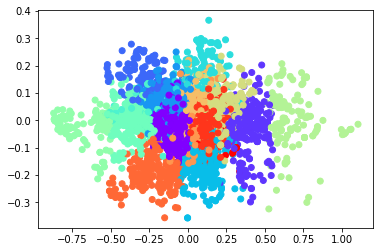

In [72]:
import matplotlib.pyplot as plt

plt.scatter(apis_df['x'], apis_df['y'], c=apis_df['cluster'], cmap='rainbow')

Text(0.5, 0.92, 'Tweet Clustering using K Means')

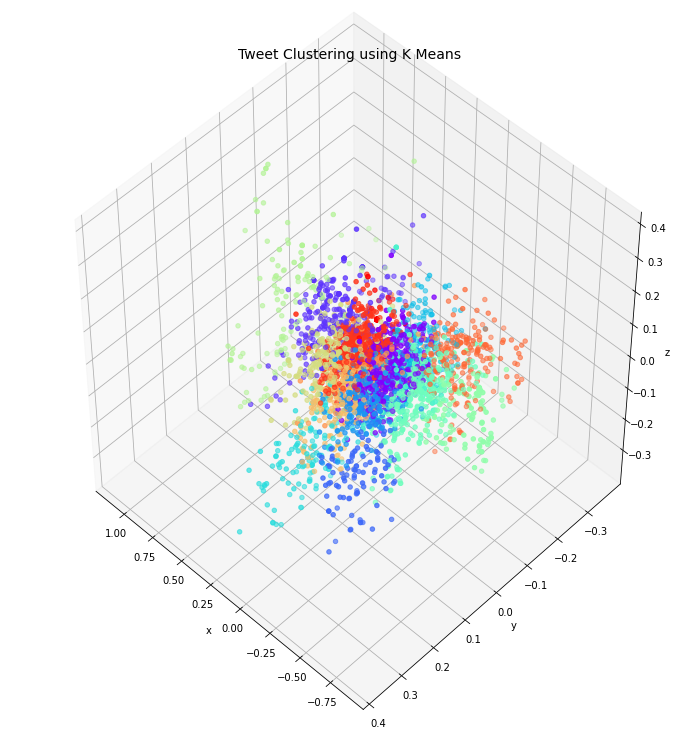

In [73]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(10,10))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(apis_df['x'],apis_df['y'],apis_df['z'], c=apis_df['cluster'], cmap='rainbow')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_facecolor('white')
plt.title("Tweet Clustering using K Means", fontsize=14)

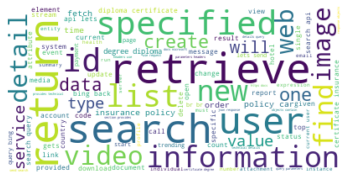

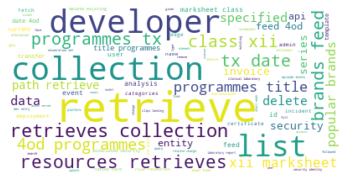

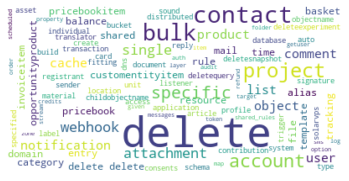

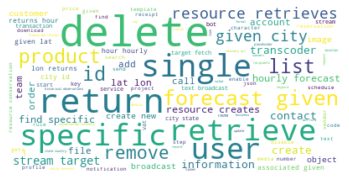

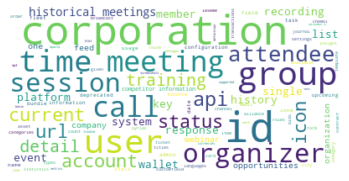

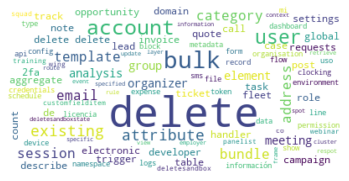

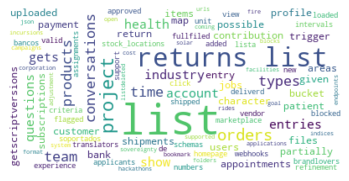

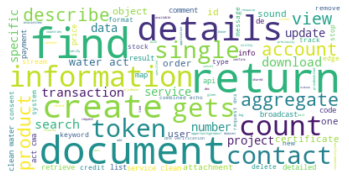

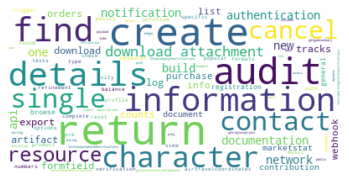

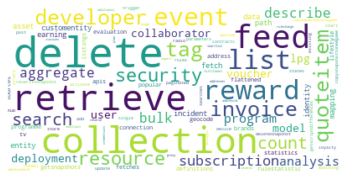

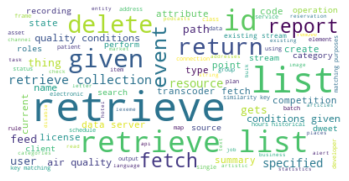

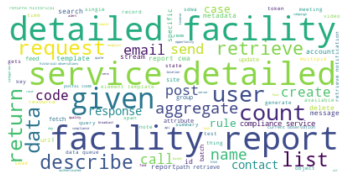

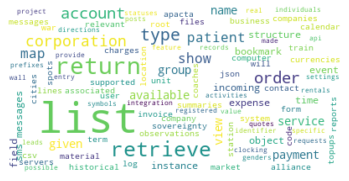

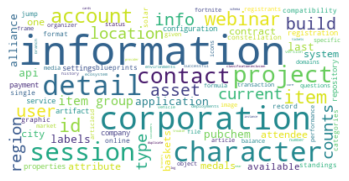

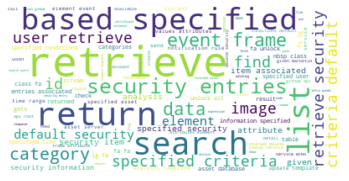

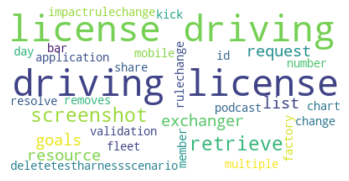

ValueError: ignored

In [74]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
k_val = 17
vectorizer = TfidfVectorizer(stop_words={'english'})
apilists = apis_df["api_summary"].to_list()
X = vectorizer.fit_transform(apilists)
clusters = list(kmeans.labels_)

kmeans_result={'cluster':clusters,'apis':apilists}
kmeans_result=pd.DataFrame(kmeans_result)
for k in range(0,k_val):
    s=kmeans_result[kmeans_result.cluster==k]
    text=s['apis'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [75]:
kmeans_result

,cluster,apis
0,0,Get quotes for all symbols
1,12,Get a list of symbols for which we provide rea...
2,7,Performs introspection of the provided Bearer ...
3,12,Retrieve a list of API Requests that have been...
4,0,Enumerate all active channels of the application
...,...,...
3673,7,all
3674,8,single-audio
3675,7,single-text
3676,2,delete


In [76]:
kmeans.labels_

array([ 0, 12,  7, ...,  7,  2,  0], dtype=int32)

In [77]:
import collections
counter=collections.Counter(kmeans.labels_)


# APIs in Clusters

In [78]:
counter

Counter({0: 554,
         1: 302,
         2: 108,
         3: 302,
         4: 207,
         5: 127,
         6: 97,
         7: 337,
         8: 105,
         9: 135,
         10: 204,
         11: 242,
         12: 151,
         13: 207,
         14: 547,
         15: 53})